In [6]:
###############################
# INITIALIZATION OF WORKSPACE #
###############################

import numpy as np
from scipy.spatial import distance
import pylab as pl
%pylab --no-import-all inline
import openturns as ot
from openturns.viewer import View
from math import sqrt, sin, pi
import matplotlib.pyplot as plt
import fsm
import EWIS_func

Populating the interactive namespace from numpy and matplotlib


In [7]:
###################################
#    PARAMETRIZATION & INPUT DATA #
###################################

## -- Generic EWIS architecture data -- ##

# Data Gauge catalog
Catalog_Gauge = np.loadtxt('./Data/Catalog_gauge.csv', delimiter=';').reshape(17,3)[:,1:]

# Data Electric Network
V0 = 28
Delta_V = 1

# Data topological architecture EWIS #
# Position EPDC
X_EPDC2_archi = [[10, 2, 0],[28, 2, 0]]
Index_archi = 1
X_EPDC2 = X_EPDC2_archi[Index_archi-1]

# Parameters to manage manufacturing aspects (industrial tolerances)
# Build-up: ties, sleeves, labels,...
C1 = 1.2
# Installation: brackets, clamps, fasteners,...
C2 = 1.4

## -- Specific EWIS architecture data -- ##

# Positions SPDC

# Special configuration for test
#X_SPDB = ot.NumericalSample([[20,2,0]])
#Nb_PSU = 1

X_SPDB = ot.NumericalSample([[20, 2, 2], [25, 2, 2], [30,2,2], [35,2,2], [40,2,2], [45,2,2], [50,2,2], [55,2,2]])
Nb_PSU = 5
Nb_PAX_PSU = 4
P_PSU = [[20,100]]

# Positions VU
X_VU = [[12,0,-2],[14,-2,-2],[14,2,-2]]
#Nb_VU = len(X_VU)
Nb_Eq_VU = 15
P_Ei_VU = [[20,140],[20,140],[20,140]]

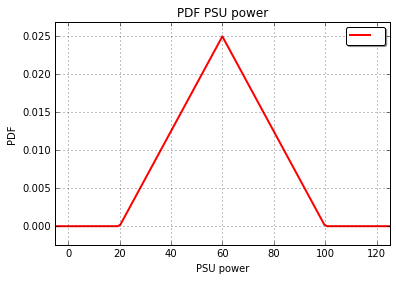

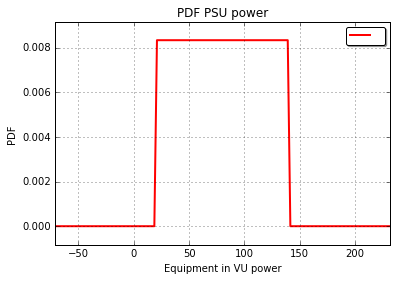

In [8]:
#######################
# Probabilistic model #
#######################

## - SPDB --#

# Marginal law of PSU
distributionMarginal_PSU = ot.Triangular(20.,60.,100.)

# - Only for test
#distributionMarginal_PSU = ot.Dirac(280.)



PDF_PSU = distributionMarginal_PSU.drawPDF()
PDF_PSU.setTitle('PDF PSU power')
PDF_PSU.setXTitle('PSU power')
PDF_PSU.setYTitle('PDF')
PDF_PSU.setLegends(' ')
View(PDF_PSU).save('PDF PSU.png')
# Independence b/t all PSU

distributionSPDB = ot.ComposedDistribution([distributionMarginal_PSU]*(len(X_SPDB)*Nb_PSU))

# Taking into account dependencies

R_SPDB = ot.CorrelationMatrix(len(X_SPDB)*Nb_PSU)
for i in range(1, len(X_SPDB)*Nb_PSU):
    R_SPDB[i, i - 1] = 0.5

#distributionSPDB= ot.ComposedDistribution([distributionMarginal_PSU]*(len(X_SPDB)*Nb_PSU), ot.NormalCopula(R_SPDB))



## - SPDB --#

distributionMarginal_Eq = ot.Uniform(20.,140.)
PDF_Eq = distributionMarginal_Eq.drawPDF()
PDF_Eq.setTitle('PDF PSU power')
PDF_Eq.setXTitle('Equipment in VU power')
PDF_Eq.setYTitle('PDF')
PDF_Eq.setLegends(' ')
View(PDF_Eq).save('PDF Eq.png')


distributionVU = ot.ComposedDistribution([distributionMarginal_Eq]*(len(X_VU)*Nb_Eq_VU))

#R_VU = ot.CorrelationMatrix(len(X_VU)*Nb_Eq_VU)
#for i in range(1, (len(X_VU)*Nb_Eq_VU)):
#    R_VU[i, i - 1] = -0.4
#distributionVU = ot.ComposedDistribution([ot.Uniform(20.,140.)]*(len(X_VU)*Nb_Eq_VU), ot.NormalCopula(R_VU))



####################
# Get input sample #
####################

sizeSample = 100000
PowerSampleSPDB = distributionSPDB.getSample(sizeSample)
PowerSampleVU = distributionVU.getSample(sizeSample)

In [9]:
################################################
# Compute lengths of cable for SPDB equipments #
################################################

# Instantiate function with "parameter" X_EPDC2
distance = ot.NumericalMathFunction(EWIS_func.DistanceFunc(X_EPDC2))

# Compute lengths for a given EWIS architecture
Dist_SPDB = distance(X_SPDB)
Dist_VU = distance(X_VU)

In [10]:
#####################################################################
# Compute Mass of the different components of the EWIS architecture #
#####################################################################

#- Compute mass of EWIS component in Cabin (linked to SPDB) -#

initMassSPDB = EWIS_func.CalcMassFunc([Nb_PSU, Delta_V*V0],(np.array(Dist_SPDB))[:,0],Catalog_Gauge)
modelMassSPDB = ot.NumericalMathFunction(initMassSPDB)
MassSample_SPDB = modelMassSPDB(PowerSampleSPDB)
MassSPDB_min = MassSample_SPDB.getMin()[0]
MassSPDB_max = MassSample_SPDB.getMax()[0]
fittedDist_Mass_SPDB = ot.KernelSmoothing().build(MassSample_SPDB)

#print "Dist_SPDB", Dist_SPDB, "PowerSampleSPDB", PowerSampleSPDB, "massSPDB", MassSample_SPDB

#- Compute mass of EWIS component in Electronic Bay (linked to VU) -#
initMassVU = EWIS_func.CalcMassFunc([Nb_Eq_VU, Delta_V*V0],(np.array(Dist_VU))[:,0],Catalog_Gauge)
modelMassVU = ot.NumericalMathFunction(initMassVU)
MassSample_VU = modelMassVU(PowerSampleVU)
MassVU_min = MassSample_VU.getMin()[0]
MassVU_max = MassSample_VU.getMax()[0]
fittedDist_Mass_VU = ot.KernelSmoothing().build(MassSample_VU)

#- Compute Total Mass of EWIS Architecture (SPDB + VU) with correcting factors C1 & C2-#

Mass_TOT = ot.RandomMixture([C1*C2*fittedDist_Mass_SPDB, C1*C2*fittedDist_Mass_VU])
MassSample_TOT = Mass_TOT.getSample(sizeSample)
MassTOT_min = MassSample_TOT.getMin()[0]
MassTOT_max = MassSample_TOT.getMax()[0]

-------------------------------------------------------------------------------
Mass SPDB: Min = 11.7577 Max =  19.2877
Mass SPDB: Quantile @ 5% =  14.1328 Quantile @ 50% =  16.0769 Quantile @ 95% =  17.7011
Mass SPDB: Normalized Interquantile 0.221951993233
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Mass of global SPDB (SPDB1 + ... + SPDB8) given in kg 

* ------ Deterministic analysis ------*
Mass SPDB: Min = 11.7577 Max =  19.2877 Delta =  7.53


* ------ Probabilistic analysis ------*
Mass SPDB: Quantile @ 5% =  14.1328 Quantile @ 50% =  16.0769 Quantile @ 95% =  17.7011
Mass SPDB: Variance = 1.14312031276 6-sigma =  6.41500828209
Mass SPDB: Interquantile (q(99,7%) - q(0,3%)) =  5.5729
-------------------------------------------------------------------------------


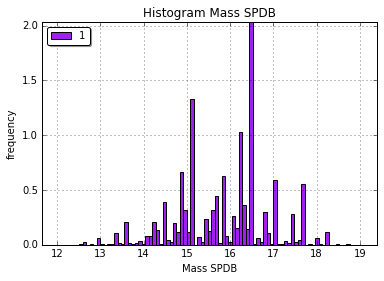

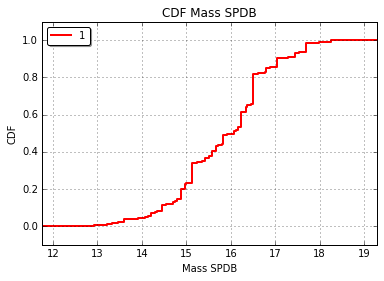

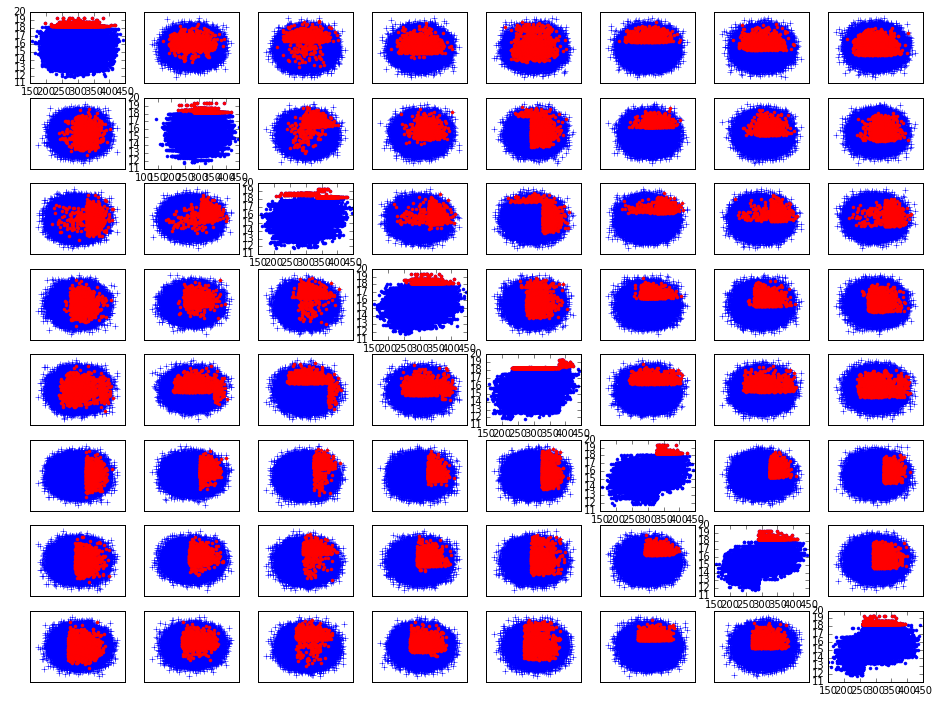

In [11]:
#################################
# Visualize SPDB Mass component #
################################# 

#- Histogram -#
histo_SPDB=ot.VisualTest.DrawHistogram(MassSample_SPDB)
histo_SPDB.setName("Histogram Mass SPDB")
histo_SPDB.setTitle("Histogram Mass SPDB")
histo_SPDB.setXTitle("Mass SPDB")
histo_SPDB.setLegends('1')
histo_SPDB.setLegendPosition('topleft')
histo_SPDB.setLegendFontSize(6)
BoundingBox_SPDB = histo_SPDB.getBoundingBox()
histo_SPDB.setBoundingBox([MassSPDB_min-0.1, MassSPDB_max+0.11,BoundingBox_SPDB[2],BoundingBox_SPDB[3]])
View(histo_SPDB).save('Histogram_Mass_SPDB 2.png')


#- CDF -#

CDF_SPDB = ot.VisualTest.DrawEmpiricalCDF(MassSample_SPDB, MassSPDB_min, MassSPDB_max)
CDF_SPDB.setName("CDF SPDB")
CDF_SPDB.setTitle("CDF Mass SPDB")
CDF_SPDB.setXTitle("Mass SPDB")
CDF_SPDB.setYTitle("CDF")
CDF_SPDB.setLegends('1')
CDF_SPDB.setLegendPosition('topleft')
View(CDF_SPDB).save('CDF_Mass_SPDB 2.png')

#- Print results -#
print "-------------------------------------------------------------------------------"
print "Mass SPDB: Min =", MassSample_SPDB.getMin()[0], "Max = ", MassSample_SPDB.getMax()[0]
print "Mass SPDB: Quantile @ 5% = ", MassSample_SPDB.computeQuantile(0.05)[0], "Quantile @ 50% = ", MassSample_SPDB.computeQuantile(0.5)[0],"Quantile @ 95% = ", MassSample_SPDB.computeQuantile(0.95)[0]
print "Mass SPDB: Normalized Interquantile", (MassSample_SPDB.computeQuantile(0.95)[0] - MassSample_SPDB.computeQuantile(0.05)[0]) / MassSample_SPDB.computeQuantile(0.5)[0]
print "-------------------------------------------------------------------------------"

#- Print results -#
print "-------------------------------------------------------------------------------"
print "Mass of global SPDB (SPDB1 + ... + SPDB8) given in kg \n"
print "* ------ Deterministic analysis ------*"
print "Mass SPDB: Min =", (MassSample_SPDB.getMin())[0], "Max = ", MassSample_SPDB.getMax()[0], "Delta = ", MassSample_SPDB.getMax()[0] - MassSample_SPDB.getMin()[0]
print "\n"
print "* ------ Probabilistic analysis ------*"
print "Mass SPDB: Quantile @ 5% = ", MassSample_SPDB.computeQuantile(0.05)[0], "Quantile @ 50% = ", MassSample_SPDB.computeQuantile(0.5)[0],"Quantile @ 95% = ", MassSample_SPDB.computeQuantile(0.95)[0]
print "Mass SPDB: Variance =", np.array(MassSample_SPDB.computeCovariance())[0][0], "6-sigma = ", 6*sqrt(np.array(MassSample_SPDB.computeCovariance())[0][0])
#print "Mass VU: Normalized Interquantile", (MassSample_VU.computeQuantile(0.95)[0] - MassSample_VU.computeQuantile(0.05)[0]) / MassSample_VU.computeQuantile(0.5)[0]
print "Mass SPDB: Interquantile (q(99,7%) - q(0,3%)) = ", (MassSample_SPDB.computeQuantile(0.997)[0] - MassSample_SPDB.computeQuantile(0.003)[0])
print "-------------------------------------------------------------------------------"




# Visualization of the sum of powers per SPDB vs the total mass of the architecture

R1 = np.array(PowerSampleSPDB).reshape(sizeSample,len(X_SPDB), Nb_PSU)
Sum_Pow_SPDB = R1.sum(axis=2)

v1 =fsm.functional_scatter_matrix(Sum_Pow_SPDB, MassSample_SPDB, ot.GreaterOrEqual(), color="blue", 
                                 values = MassSample_SPDB.computeQuantile(0.99), colors = ["red"])
v1._fig.set_size_inches(16, 12)

-------------------------------------------------------------------------------
Mass of global VU (VU0 + VU1 + VU2) given in kg 

* ------ Deterministic analysis ------*
Mass VU: Min = 0.858 Max =  1.7274 Delta =  0.8694


* ------ Probabilistic analysis ------*
Mass VU: Quantile @ 5% =  1.105 Quantile @ 50% =  1.4014 Quantile @ 95% =  1.7274
Mass VU: Variance = 0.0370928088772 6-sigma =  1.15556960828
Mass VU: Interquantile (q(99,7%) - q(0,3%)) =  0.6224
-------------------------------------------------------------------------------


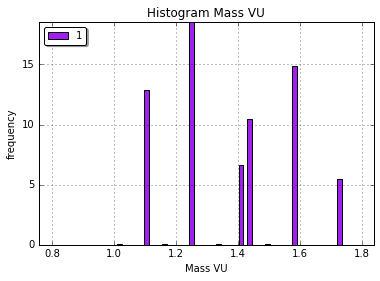

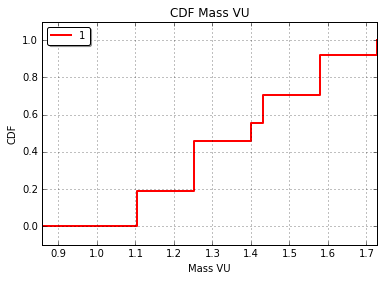

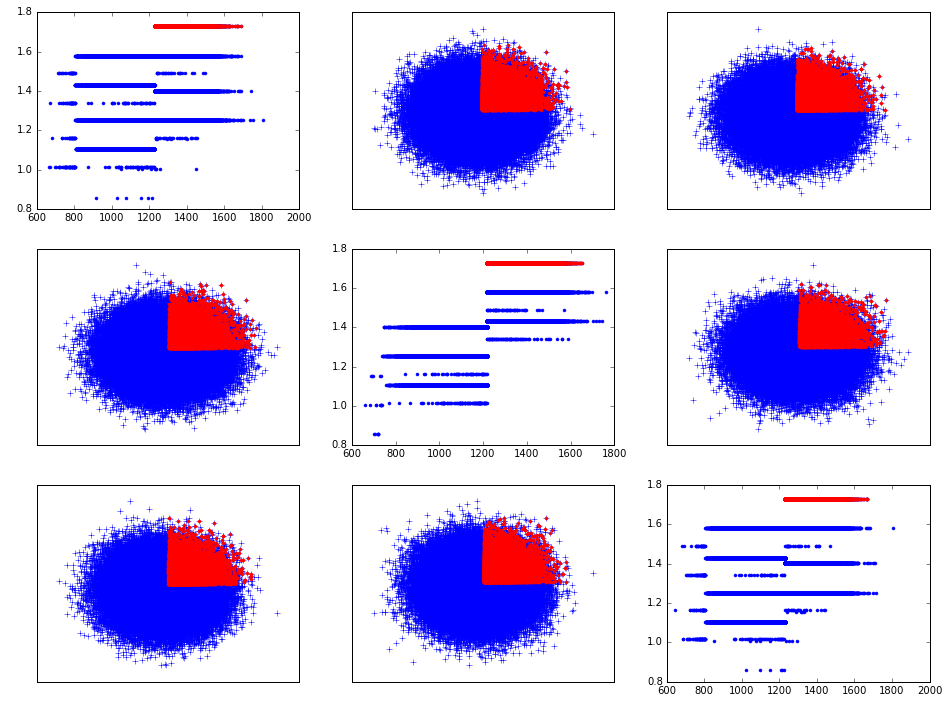

In [12]:
#################################
# Visualize VU Mass component #
################################# 

#- Histogram -#
histo_VU=ot.VisualTest.DrawHistogram(MassSample_VU)
histo_VU.setName("Histogram Mass VU")
histo_VU.setTitle("Histogram Mass VU")
histo_VU.setXTitle("Mass VU")
histo_VU.setLegends('1')
histo_VU.setLegendPosition('topleft')
histo_VU.setLegendFontSize(6)
BoundingBox_VU = histo_VU.getBoundingBox()
histo_VU.setBoundingBox([MassVU_min-0.1, MassVU_max+0.11,BoundingBox_VU[2],BoundingBox_VU[3]])
View(histo_VU).save('Histogram_Mass_VU 2.png')


#- CDF -#

CDF_VU = ot.VisualTest.DrawEmpiricalCDF(MassSample_VU, MassVU_min, MassVU_max)
CDF_VU.setName("CDF VU")
CDF_VU.setTitle("CDF Mass VU")
CDF_VU.setXTitle("Mass VU")
CDF_VU.setYTitle("CDF")
CDF_VU.setLegends('1')
CDF_VU.setLegendPosition('topleft')
View(CDF_VU).save('CDF_Mass_VU 2.png')

#- Print results -#
print "-------------------------------------------------------------------------------"
print "Mass of global VU (VU0 + VU1 + VU2) given in kg \n"
print "* ------ Deterministic analysis ------*"
print "Mass VU: Min =", (MassSample_VU.getMin())[0], "Max = ", MassSample_VU.getMax()[0], "Delta = ", MassSample_VU.getMax()[0] - MassSample_VU.getMin()[0]
print "\n"
print "* ------ Probabilistic analysis ------*"
print "Mass VU: Quantile @ 5% = ", MassSample_VU.computeQuantile(0.05)[0], "Quantile @ 50% = ", MassSample_VU.computeQuantile(0.5)[0],"Quantile @ 95% = ", MassSample_VU.computeQuantile(0.95)[0]
print "Mass VU: Variance =", np.array(MassSample_VU.computeCovariance())[0][0], "6-sigma = ", 6*sqrt(np.array(MassSample_VU.computeCovariance())[0][0])
#print "Mass VU: Normalized Interquantile", (MassSample_VU.computeQuantile(0.95)[0] - MassSample_VU.computeQuantile(0.05)[0]) / MassSample_VU.computeQuantile(0.5)[0]
print "Mass VU: Interquantile (q(99,7%) - q(0,3%)) = ", (MassSample_VU.computeQuantile(0.997)[0] - MassSample_VU.computeQuantile(0.003)[0])
print "-------------------------------------------------------------------------------"



# Visualization of the sum of powers per SPDB vs the total mass of the architecture

R2 = np.array(PowerSampleVU).reshape(sizeSample,len(X_VU), Nb_Eq_VU)
Sum_Pow_VU = R2.sum(axis=2)

v2 =fsm.functional_scatter_matrix(Sum_Pow_VU, MassSample_VU, ot.GreaterOrEqual(), color="blue", 
                                 values = MassSample_VU.computeQuantile(0.99), colors = ["red"])
v2._fig.set_size_inches(16, 12)

In [13]:
type(v2)
#View(v2).save('SensitivityVU.png')

openturns.viewer.View

-------------------------------------------------------------------------------
Total Mass of EWIS (SPDB part + VU Part) given in kg 

* ------ Deterministic analysis ------*
Mass TOT: Min = 3.29219334809 Max =  62.5160300929 Delta =  59.2238367448


* ------ Probabilistic analysis ------*
Mass SPDB: Quantile @ 5% =  3.96502932258 Quantile @ 50% =  24.5232650406 Quantile @ 95% =  56.4644438288
Mass SPDB: Variance = 595.174503478 6-sigma =  146.377191274
Mass SPDB: Interquantile (q(99,7%) - q(0,3%)) =  55.5423589925
-------------------------------------------------------------------------------


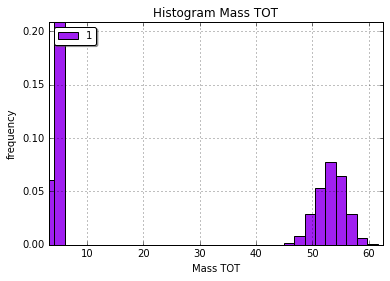

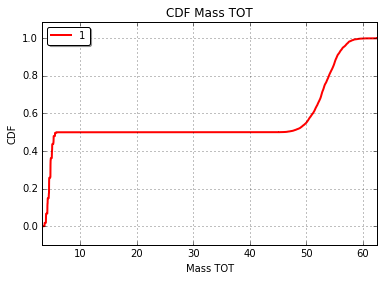

In [14]:
#######################
# Visualize  Mass TOT #
####################### 

#- Histogram -#
histo_TOT=ot.VisualTest.DrawHistogram(MassSample_TOT)
histo_TOT.setName("Histogram Mass TOT")
histo_TOT.setTitle("Histogram Mass TOT")
histo_TOT.setXTitle("Mass TOT")
histo_TOT.setLegends('1')
histo_TOT.setLegendPosition('topleft')
histo_TOT.setLegendFontSize(6)
BoundingBox_TOT = histo_TOT.getBoundingBox()
histo_TOT.setBoundingBox([MassTOT_min-0.1, MassTOT_max+0.11,BoundingBox_TOT[2],BoundingBox_TOT[3]])
View(histo_TOT).save('Histogram_Mass_TOT 2.png')


#- CDF -#

CDF_TOT = ot.VisualTest.DrawEmpiricalCDF(MassSample_TOT, MassTOT_min, MassTOT_max)
CDF_TOT.setName("CDF TOT")
CDF_TOT.setTitle("CDF Mass TOT")
CDF_TOT.setXTitle("Mass TOT")
CDF_TOT.setYTitle("CDF")
CDF_TOT.setLegends('1')
CDF_TOT.setLegendPosition('topleft')
View(CDF_TOT).save('CDF_Mass_TOT 2.png')

#- Print results -#
print "-------------------------------------------------------------------------------"
print "Total Mass of EWIS (SPDB part + VU Part) given in kg \n"
print "* ------ Deterministic analysis ------*"
print "Mass TOT: Min =", (MassSample_TOT.getMin())[0], "Max = ", MassSample_TOT.getMax()[0], "Delta = ", MassSample_TOT.getMax()[0] - MassSample_TOT.getMin()[0]
print "\n"
print "* ------ Probabilistic analysis ------*"
print "Mass SPDB: Quantile @ 5% = ", MassSample_TOT.computeQuantile(0.05)[0], "Quantile @ 50% = ", MassSample_TOT.computeQuantile(0.5)[0],"Quantile @ 95% = ", MassSample_TOT.computeQuantile(0.95)[0]
print "Mass SPDB: Variance =", np.array(MassSample_TOT.computeCovariance())[0][0], "6-sigma = ", 6*sqrt(np.array(MassSample_TOT.computeCovariance())[0][0])
#print "Mass VU: Normalized Interquantile", (MassSample_VU.computeQuantile(0.95)[0] - MassSample_VU.computeQuantile(0.05)[0]) / MassSample_VU.computeQuantile(0.5)[0]
print "Mass SPDB: Interquantile (q(99,7%) - q(0,3%)) = ", (MassSample_TOT.computeQuantile(0.997)[0] - MassSample_TOT.computeQuantile(0.003)[0])
print "-------------------------------------------------------------------------------"





# Visualization of the sum of powers per SPDB vs the total mass of the architecture

#R2 = np.array(PowerSampleVU).reshape(sizeSample,len(X_VU), Nb_Eq_VU)
#Sum_Pow_VU = R2.sum(axis=2)

#v2 =fsm.functional_scatter_matrix(Sum_Pow_VU, MassSample_VU, ot.GreaterOrEqual(), color="blue", 
#                                 values = MassSample_VU.computeQuantile(0.99), colors = ["red"])
#v2._fig.set_size_inches(16, 12)

40
12341


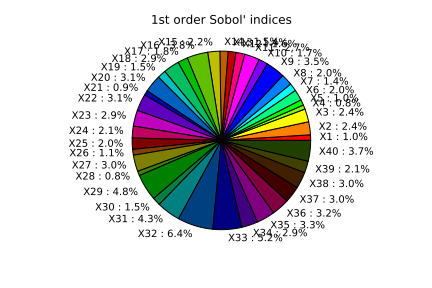

In [15]:
################################################
# Building Polynomial Chaos expansion for SPDB #
################################################ 

inputDim = (len(X_SPDB)*Nb_PSU)

polyColl = [0.0]*inputDim
print inputDim
for i in range(distributionSPDB.getDimension()):
    polyColl[i] = ot.StandardDistributionPolynomialFactory(distributionSPDB.getMarginal(i))
    
enumerateFunction = ot.LinearEnumerateFunction(inputDim)
productBasis = ot.OrthogonalProductPolynomialFactory(polyColl, enumerateFunction)

#Define the strategy to truncate the multivariate orthonormal basis: We choose all the polynomials of degree <= 3

degree = 3
indexMax = enumerateFunction.getStrataCumulatedCardinal(degree)
print(indexMax)

# We keep all the polynomials of degree <= 4 (which corresponds to the 5 first ones):

adaptiveStrategy = ot.FixedStrategy(productBasis, indexMax)
# Define the evaluation strategy of the coefficients:

samplingSize = 10000
experiment = ot.MonteCarloExperiment(samplingSize)
projectionStrategy = ot.LeastSquaresStrategy(experiment)
# Create the Functional Chaos Algorithm:

algo = ot.FunctionalChaosAlgorithm(modelMassSPDB, distributionSPDB, adaptiveStrategy, projectionStrategy)
algo.run()
# Get the result:

functionalChaosResultSPDB = algo.getResult()
metamodelSPDB = functionalChaosResultSPDB.getMetaModel()


########################
# Sensitivity Analysis #
######################## 

sensitivityAnalysis = ot.FunctionalChaosRandomVector(functionalChaosResultSPDB)
str1 = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18','X19','X20']
str2 = ['X21','X22','X23','X24','X25','X26','X27','X28','X29','X30','X31','X32','X33','X34','X35','X36','X37','X38','X39','X40']
input_names = str1+str2

first_order = list(map(lambda i: sensitivityAnalysis.getSobolIndex(i), range(distributionSPDB.getDimension())))
ot.SaltelliSensitivityAlgorithm.DrawImportanceFactors(first_order, input_names, '1st order Sobol\' indices')

In [16]:
################################################
# Building Polynomial Chaos expansion for VU #
################################################ 

inputDim = (len(X_VU)*Nb_Eq_VU)

polyColl = [0.0]*inputDim
print inputDim
for i in range(distributionVU.getDimension()):
    polyColl[i] = ot.StandardDistributionPolynomialFactory(distributionVU.getMarginal(i))
    
enumerateFunction = ot.LinearEnumerateFunction(inputDim)
productBasis = ot.OrthogonalProductPolynomialFactory(polyColl, enumerateFunction)

#Define the strategy to truncate the multivariate orthonormal basis: We choose all the polynomials of degree <= 3

degree = 3
indexMax = enumerateFunction.getStrataCumulatedCardinal(degree)
print(indexMax)

# We keep all the polynomials of degree <= 4 (which corresponds to the 5 first ones):

adaptiveStrategy = ot.FixedStrategy(productBasis, indexMax)
# Define the evaluation strategy of the coefficients:

samplingSize = 10000
experiment = ot.MonteCarloExperiment(samplingSize)
projectionStrategy = ot.LeastSquaresStrategy(experiment)
# Create the Functional Chaos Algorithm:

algo = ot.FunctionalChaosAlgorithm(modelMassVU, distributionVU, adaptiveStrategy, projectionStrategy)
algo.run()
# Get the result:

functionalChaosResultVU = algo.getResult()
metamodelVU = functionalChaosResultSPDB.getMetaModel()


########################
# Sensitivity Analysis #
######################## 

sensitivityAnalysis = ot.FunctionalChaosRandomVector(functionalChaosResultSPDB)
str1 = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18','X19','X20']
str2 = ['X21','X22','X23','X24','X25','X26','X27','X28','X29','X30','X31','X32','X33','X34','X35','X36','X37','X38','X39','X40']
str3 = ['X41','X42','X43','X44','X45']

input_names = str1+str2+str3

first_order = list(map(lambda i: sensitivityAnalysis.getSobolIndex(i), range(distributionVU.getDimension())))
ot.SaltelliSensitivityAlgorithm.DrawImportanceFactors(first_order, input_names, '1st order Sobol\' indices')

45
17296


TypeError: InvalidArgumentException : The variable indices of a Sobol indice must be in the range [0, dim-1] and  must be different.

In [ ]:
v2

In [ ]:
########################
# Sensitivity Analysis #
######################## 

sensitivityAnalysis = ot.FunctionalChaosRandomVector(functionalChaosResultSPDB)
str1 = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18','X19','X20']
str2 = ['X21','X22','X23','X24','X25','X26','X27','X28','X29','X30','X31','X32','X33','X34','X35','X36','X37','X38','X39','X40']
input_names = str1+str2

first_order = list(map(lambda i: sensitivityAnalysis.getSobolIndex(i), range(distributionSPDB.getDimension())))
ot.SaltelliSensitivityAlgorithm.DrawImportanceFactors(first_order, input_names, '1st order Sobol\' indices')

In [ ]:

########################
# Sensitivity Analysis #
######################## 

sensitivityAnalysis = ot.FunctionalChaosRandomVector(functionalChaosResultSPDB)
str1 = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18','X19','X20']
str2 = ['X21','X22','X23','X24','X25','X26','X27','X28','X29','X30','X31','X32','X33','X34','X35','X36','X37','X38','X39','X40']
str3 = ['X41','X42','X43','X44','X45']

input_names = str1+str2+str3

first_order = list(map(lambda i: sensitivityAnalysis.getSobolIndex(i), range(distributionVU.getDimension())))
ot.SaltelliSensitivityAlgorithm.DrawImportanceFactors(first_order, input_names, '1st order Sobol\' indices')

In [ ]:
################################################
# Building Polynomial Chaos expansion for EWIS #
################################################ 

inputDim = 2

polyColl = [0.0]*inputDim
print inputDim
for i in range(MassTOT.getDimension()):
    polyColl[i] = ot.StandardDistributionPolynomialFactory(MassTOT.getMarginal(i))
    
enumerateFunction = ot.LinearEnumerateFunction(inputDim)
productBasis = ot.OrthogonalProductPolynomialFactory(polyColl, enumerateFunction)

#Define the strategy to truncate the multivariate orthonormal basis: We choose all the polynomials of degree <= 3

degree = 3
indexMax = enumerateFunction.getStrataCumulatedCardinal(degree)
print(indexMax)

# We keep all the polynomials of degree <= 4 (which corresponds to the 5 first ones):

adaptiveStrategy = ot.FixedStrategy(productBasis, indexMax)
# Define the evaluation strategy of the coefficients:

samplingSize = 10000
experiment = ot.MonteCarloExperiment(samplingSize)
projectionStrategy = ot.LeastSquaresStrategy(experiment)
# Create the Functional Chaos Algorithm:

algo = ot.FunctionalChaosAlgorithm(modelMassSPDB, MassTOT, adaptiveStrategy, projectionStrategy)
algo.run()
# Get the result:

functionalChaosResultTOT = algo.getResult()
metamodelTOT = functionalChaosResultSPDB.getMetaModel()


########################
# Sensitivity Analysis #
######################## 

sensitivityAnalysis = ot.FunctionalChaosRandomVector(functionalChaosResultSPDB)
str1 = ['SPDB','VU']

first_order = list(map(lambda i: sensitivityAnalysis.getSobolIndex(i), range(distributionVU.getDimension())))
ot.SaltelliSensitivityAlgorithm.DrawImportanceFactors(first_order, input_names, '1st order Sobol\' indices')